## Fashion MNIST

In [27]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

torch.random.manual_seed(531)

fashion_train = FashionMNIST("datasets", download=True, transform=ToTensor())
fashion_val = FashionMNIST("datasets", train=False, transform=ToTensor())
print(fashion_train.data.shape)

torch.Size([60000, 28, 28])


In [0]:
train_loader = DataLoader(fashion_train, 32, shuffle=True)
val_loader = DataLoader(fashion_val, 32)

In [29]:
x, y = next(iter(train_loader))
x.min(), x.max()

(tensor(0.), tensor(1.))

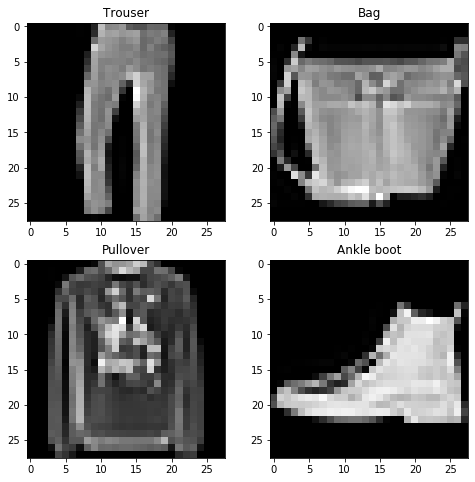

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8,8))
for i, axis in enumerate(axes.ravel()):
    img = x[i, 0, ...].numpy()
    label = fashion_train.classes[y[i]]
    axis.imshow(img, cmap="gray")
    axis.set_title(label)

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

model = resnet50(pretrained=False, num_classes=10).to("cuda")
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.1)

In [0]:
# metric definitions
from IPython.display import clear_output

def accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            pred = model(x.to("cuda").expand(-1, 3, -1, -1))
            correct += (pred.argmax(dim=1) == y.to("cuda")).sum()
            total += y.shape[0]
    return correct.item() / total

def plot_metrics(metrics):
    clear_output()
    plt.figure(figsize=(6, 5))
    for name, (xs, ys) in metrics.items():
        plt.plot(xs, ys, label=name)
    plt.legend()
    plt.show()

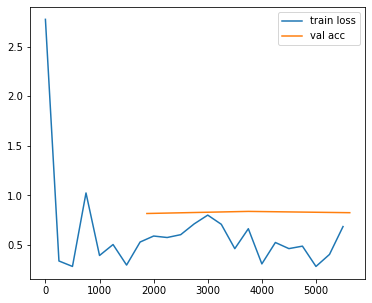

In [50]:
# train
epochs = 3
train_loss = []
val_accuracy = []
batch_no_train = []
batch_no_val = []
batch_no = 0
for epoch in range(epochs):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        
        pred = model(x.to("cuda").expand(-1, 3, -1, -1))
        loss = F.cross_entropy(pred, y.to("cuda"))
        loss.backward()
        
        optimizer.step()
        
        if batch_no % 250 == 0:
            train_loss.append(loss)
            batch_no_train.append(batch_no)
            plot_metrics({"train loss": (batch_no_train, train_loss), 
                  "val acc": (batch_no_val, val_accuracy)})
        batch_no += 1
            
    val_accuracy.append(accuracy(model, val_loader))
    batch_no_val.append(batch_no)
    plot_metrics({"train loss": (batch_no_train, train_loss), 
                  "val acc": (batch_no_val, val_accuracy)})
    lr_scheduler.step()

In [51]:
val_accuracy

[0.8166, 0.8378, 0.8247]

## Imagewoof

In [0]:
%%bash
curl https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz -o imagewoof2-160.tgz
tar -xf imagewoof2-160.tgz -C datasets/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 88.2M  100 88.2M    0     0  63.0M      0  0:00:01  0:00:01 --:--:-- 63.0M


In [0]:
%ls datasets/

FashionMNIST/  imagewoof2-160/


In [0]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

def prepare_imagewoof(augment=False):
    tfs = [transforms.Resize((128, 128))]
    if augment:
        tfs.extend([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.25, 0.3, 0.2, 0.),
            transforms.RandomRotation(30)])
    tfs.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean and std
    ])
    return transforms.Compose(tfs)

imagewoof_train = ImageFolder("datasets/imagewoof2-160/train", transform=prepare_imagewoof(True))
imagewoof_val = ImageFolder("datasets/imagewoof2-160/val", transform=prepare_imagewoof(False))

In [0]:
imagewoof_classes_human_readable = {
    "n02086240": "Shih Tzu",
    "n02087394": "Rhodesian ridgeback",
    "n02088364": "Beagle",
    "n02089973": "English foxhound",
    "n02093754": "Border terrier",
    "n02096294": "Australian terrier",
    "n02099601": "Golden retriever",
    "n02105641": "Old English sheepdog",
    "n02111889": "Samoyed",
    "n02115641": "dingo"
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


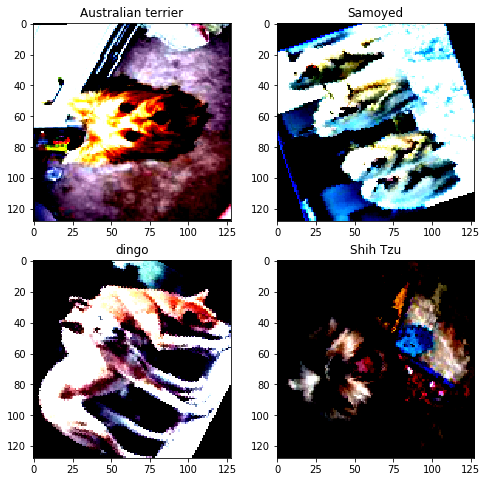

In [77]:
torch.random.manual_seed(693)
train_loader = DataLoader(imagewoof_train, 16, True, num_workers=4, drop_last=True)
val_loader = DataLoader(imagewoof_val, 16, num_workers=4)

x, y = next(iter(train_loader))

fig, axes = plt.subplots(2, 2, figsize=(8,8))
for i, axis in enumerate(axes.ravel()):
    img = x[i,  ...].transpose(0,2).numpy()
    label = imagewoof_classes_human_readable[imagewoof_train.classes[y[i]]]
    axis.imshow(img, cmap="gray")
    axis.set_title(label)

In [0]:
model = resnet50(num_classes=10).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), 8e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "max", patience=5)

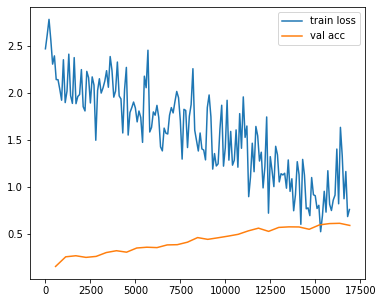

In [79]:
epochs = 30
train_loss = []
val_accuracy = []
batch_no_train = []
batch_no_val = []
batch_no = 0
for epoch in range(epochs):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        
        pred = model(x.to("cuda"))
        loss = F.cross_entropy(pred, y.to("cuda"))
        loss.backward()
        
        optimizer.step()
        
        if batch_no % 100 == 0:
            train_loss.append(loss)
            batch_no_train.append(batch_no)
            plot_metrics({"train loss": (batch_no_train, train_loss), 
                  "val acc": (batch_no_val, val_accuracy)})
        batch_no += 1
            
    val_accuracy.append(accuracy(model, val_loader))
    batch_no_val.append(batch_no)
    plot_metrics({"train loss": (batch_no_train, train_loss), 
                  "val acc": (batch_no_val, val_accuracy)})
    lr_scheduler.step(val_accuracy[-1])

In [80]:
val_accuracy[-10:]

[0.5609569865105625,
 0.526851616187325,
 0.5688470348689234,
 0.5747009417154493,
 0.5736828709595316,
 0.5489946551285314,
 0.5953168745227794,
 0.6095698651056248,
 0.6126240773733774,
 0.5899720030542123]

## Multitask model

In [0]:
backbone = resnet50(pretrained=False)